In [1]:
import pandas as pd
import re
import gensim
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.parsing.preprocessing import preprocess_string
import pyLDAvis
import pyLDAvis.gensim_models
from natasha import (
    Segmenter,
    MorphVocab,
    NewsEmbedding,
    NewsMorphTagger,
    Doc
)

# Dataset

In [2]:
submit = pd.read_csv('C:\\Users\\16689\\Downloads\\hse_hak2_data\\submit_example.csv')
submit.head(3)

solution_id       author_comment  \
0            0  Ваше предсказание 0   
1            1  Ваше предсказание 1   
2            2  Ваше предсказание 2   

                            author_comment_embedding  
0  -0.18125976622104645 -1.1729670763015747 0.099...  
1  0.15930218994617462 -0.6560381054878235 0.6637...  
2  0.05616343021392822 -0.3004266321659088 0.2350...

### solutions

In [3]:
solutions_train = pd.read_excel('C:\\Users\\16689\\Downloads\\hse_hak2_data\\train\\solutions.xlsx')
solutions_train.head(3)

id  task_id                                   student_solution  \
0  13        1  logo_project = ['#a7a8f0', '#a7f0ca', '#b3b4e4...   
1  14        1  logo_project = ['#a7a8f0', '#a7f0ca', '#b3b4e4...   
2  15        1  logo_project = ['#a7a8f0', '#a7f0ca', '#b3b4e4...   

                                      author_comment  \
0  Ошибка в открытых тестах. \n\nОбратите внимани...   
1  Ошибка в открытых тестах. \n\nОбратите внимани...   
2  Ошибка в открытых тестах. \n\nОбратите внимани...   

                            author_comment_embedding  
0  -0.2475823611021042 -1.3317935466766357 0.2535...  
1  -0.25970256328582764 -1.4550446271896362 0.333...  
2  -0.28293243050575256 -1.4774413108825684 0.243...

In [4]:
solutions_train.loc[0]['student_solution']

"logo_project = ['#a7a8f0', '#a7f0ca', '#b3b4e4', '#e4b3cd', '#e4e3b3', '#c0ced7']\ncite_project = ['#e4e3b3', '#a7a8f0', '#ccb1e6', '#b4f99e', '#f9b59e', '#c0ced7']\n\ncolor = input()\n\nif color in logo_project and color in cite_project:\n    print(True)\nelse:\n    print(False)"

In [5]:
solutions_train.loc[0]['author_comment']

'Ошибка в открытых тестах. \n\nОбратите внимание на неверный оператор сравнения — необходимо проверить, что цвет не находится в списке cite_project.'

### tasks

In [6]:
tasks_train = pd.read_excel('C:\\Users\\16689\\Downloads\\hse_hak2_data\\train\\tasks.xlsx')
tasks_train.head(3)

id level                                        description  \
0   1     B  Реализуйте программу, которая проверит, что цв...   
1   2     B  Реализуйте программу, которая определит количе...   
2  38     B  Реализуйте следующую программу:\n\nЗадан пусто...   

                                     author_solution  
0  logo_project = ['#a7a8f0', '#a7f0ca', '#b3b4e4...  
1  result = 0\n\nwhile True:\n    info = input()\...  
2  winners = []\n\n# ваш код\n\nwhile True:\n    ...

In [7]:
tasks_train.loc[0]['description']

'Реализуйте программу, которая проверит, что цвет используется только в проекте по созданию логотипа, но не в проекте по созданию дизайна сайта:\n\nДаны два списка logo_project и cite_project с кодами используемых цветов (строки).\nВ переменную color считывается код цвета (строка). Этот код уже написан.\nПрограмма должна проверять, что код цвета color есть только в списке logo_project, и если да, то печатать True. \nВ остальных случаях программа печатает False. '

### tests

In [8]:
tests_train = pd.read_excel('C:\\Users\\16689\\Downloads\\hse_hak2_data\\train\\tests.xlsx')
tests_train.head(20)

id  number  task_id    type  \
0    5       0        1    open   
1    6       1        1    open   
2    7       2        1    open   
3    8       3        1  closed   
4    9       4        1  closed   
5   10       0        2    open   
6   11       1        2    open   
7   12       2        2  closed   
8   13       3        2  closed   
9   14       4        2  closed   
10  15       0        3    open   
11  16       1        3    open   
12  17       2        3    open   
13  18       3        3  closed   
14  19       4        3  closed   
15  20       5        3  closed   
16  36       0        6    open   
17  37       1        6    open   
18  38       2        6  closed   
19  39       3        6  closed   

                                                input  \
0                                             #a7f0ca   
1                                             #e4e3b3   
2                                             #a7a8f0   
3                                             #c0ced7   
4                                             #a7f0ca   
5   ПРОЕКТ 1\nПРОЕКТ_2\nпроект 3\nПроект_4\nинтерь...   
6        ПРОЕКТ_1\nработа_ФИН\nФинальная_работа\nСТОП   
7   123_ПРОГА_П\n123_прога_п\n123ПРОГАП?\n123 ПРОГ...   
8   _дизайнер_\n_ПРОГРАМИСТ_\n_пробный\nПРОЕКТ!\n_...   
9        ПРОЕКТ_1\nПРОЕКТ_2\nПРОЕКТ_3\nПРОЕКТ!4\nСТОП   
10  Выучите китайский язык без усилий выполняя зад...   
11  Ваш вопрос ( #question ) - наш ответ ( #answer...   
12                   Мощный рывок для Вашего @бизнеса   
13  Я никогда не был #счастье1 #любовь123 #123_123...   
14  9 из 10 экспертов рекомендуют # наш #_1223 про...   
15  # #123 #qswr_1 @qws1 $1#qwd 1#123_qwe #0 #____...   
16  ['Круглов', 'Квадратов', 'Иванов', 'Марков', '...   
17  ['Елисеев', 'Краков'], ['67', '100'], ['Санкт-...   
18  ['Петров', 'Иванов', 'Волков', 'Меньшов'], ['5...   
19  ['Елисеев', 'Воробьев', 'Стариков'], ['100', '...   

                             output  
0                              True  
1                             False  
2                             False  
3                             False  
4                              True  
5                                 1  
6                                 0  
7                                 1  
8                                 1  
9                                 1  
10                    #the_best_app  
11               #question, #answer  
12                              NaN  
13  #счастье1, #любовь123, #123_123  
14                   #, #_1223, #__  
15      #, #qswr_1, #____, #$567123  
16                          Гуськов  
17                           Краков  
18                           Волков  
19                         Стариков

In [9]:
len(solutions_train), len(tasks_train), len(tests_train)


(347, 22, 105)

### solutions

In [10]:
solutions_test = pd.read_excel('C:\\Users\\16689\\Downloads\\hse_hak2_data\\test\\solutions.xlsx')
solutions_test.head(3)

id  task_id                                   student_solution  \
0   0        0  discount  = float(input())\nmoney = int(input(...   
1   1        0  discount  = float(input())\nmoney = int(input(...   
2   2        0  discount  = float(input())\nmoney = int(input(...   

      author_comment  author_comment_embedding  
0  Ваше предсказание                       NaN  
1  Ваше предсказание                       NaN  
2  Ваше предсказание                       NaN

### tasks

In [11]:
tasks_test = pd.read_excel('C:\\Users\\16689\\Downloads\\hse_hak2_data\\test\\tasks.xlsx')
tasks_test.head(3)

id level                                        description  \
0   0     B  Реализуйте программу, которая напечатает стоим...   
1   4     B  Дизайнер К. хочет подобрать цветовую гамму для...   
2   5     B  Реализуйте программу, которая определит назван...   

                                     author_solution  
0  discount  = float(input())\nmoney = int(input(...  
1  allowed_colors = set(input().split(', '))\nfav...  
2  studios = {\n    \n    'Rutemple Studio': {'Ск...

### tests

In [12]:
tests_test = pd.read_excel('C:\\Users\\16689\\Downloads\\hse_hak2_data\\test\\tests.xlsx')
tests_test.head(20)

id  number  task_id    type  \
0    0       0        0    open   
1    1       1        0    open   
2    2       2        0    open   
3    3       3        0  closed   
4    4       4        0  closed   
5   21       0        4    open   
6   22       1        4    open   
7   23       2        4  closed   
8   24       3        4  closed   
9   25       4        4  closed   
10  26       0        5    open   
11  27       1        5    open   
12  28       2        5    open   
13  29       3        5  closed   
14  30       4        5  closed   
15  31       5        5  closed   
16  32       6        5  closed   
17  33       7        5  closed   
18  34       8        5  closed   
19  35       9        5  closed   

                                                input  \
0                                            0.1; 500   
1                                        0.05; 900000   
2                                          0; 2345678   
3                                            0.5; 100   
4                                     0.003; 12345667   
5   Умеренный синий, Серый, Желтый, Гранитный Спар...   
6   Алый, Белый, Бордо, Нефритовый, Пастельно-зеле...   
7                                 Синий\nСиний\nСиний   
8   Слоновая кость, Серый, Желтый, Спаржа, Индиго,...   
9   Слоновая кость, Серый, Желтый, Спаржа, Телегре...   
10                                            кабинет   
11                                              гараж   
12                                          гостинная   
13                                   гостевой санузел   
14                                            санузел   
15                                     мастер-спальня   
16                                           столовая   
17                                           прихожая   
18                                        гардеробная   
19                                           прихожая   

                                               output  
0   Реализация проекта будет стоить 500 тыс. руб. ...  
1   Реализация проекта будет стоить 900000 тыс. ру...  
2   Реализация проекта будет стоить 2345678 тыс. р...  
3   Реализация проекта будет стоить 100 тыс. руб. ...  
4   Реализация проекта будет стоить 12345667 тыс. ...  
5                           Желтый; Пурпурный; Серый!  
6                                                   !  
7                                              Синий!  
8                                    Индиго; Красный!  
9                                                   !  
10  Британика/Монтевиль/Риверсайд/Сканди-парк/Теат...  
11  Британика/Гринфилд/Монтевиль/Риверсайд/Сканди-...  
12                                                NaN  
13  Британика/Гринфилд/Монтевиль/Риверсайд/Сканди-...  
14  Британика/Гринфилд/Монтевиль/Сканди-парк/Театр...  
15  Британика/Гринфилд/Монтевиль/Риверсайд/Театрал...  
16                                                NaN  
17             Британика/Гринфилд/Монтевиль/Риверсайд  
18  Британика/Гринфилд/Монтевиль/Риверсайд/Сканди-...  
19             Британика/Гринфилд/Монтевиль/Риверсайд

In [13]:
from sklearn.model_selection import train_test_split

df_train = solutions_train.merge(tasks_train.rename(columns={'id': 'task_id'}), on='task_id', how='left')
df_test = solutions_test.merge(tasks_test.rename(columns={'id': 'task_id'}), on='task_id', how='left')

unit_map_train = lambda row: tests_train[tests_train['task_id'] == row.task_id][['type', 'input', 'output']] \
    .rename(columns={'type': 'Тип теста', 'input': 'Вход', 'output': 'Верный вывод программы'}) \
    .to_string(index=False)
unit_map_test = lambda row: tests_test[tests_test['task_id'] == row.task_id][['type', 'input', 'output']] \
    .rename(columns={'type': 'Тип теста', 'input': 'Вход', 'output': 'Верный вывод программы'}) \
    .to_string(index=False)

df_train['unit_true'] = df_train.apply(unit_map_train, axis=1)
df_test['unit_true'] = df_test.apply(unit_map_test, axis=1)
df_test['author_comment'] = ''

system = 'Вы учитель и вы должны на русском языке давать подсказки без прямых исправлений кода, поддерживая формальный и дружелюбный стиль общения'
df_train['system'] = df_test['system'] = system

df_train_train, df_train_test = train_test_split(df_train, test_size=0.1, random_state=42)

# df_train.to_csv('./data/raw/train/data_full.csv')
df_train_train.to_csv('data_full_train.csv')
df_train_test.to_csv('data_full_test.csv')
df_test.to_csv('data_full.csv')

In [14]:
df_train.head(5)

id  task_id                                   student_solution  \
0  13        1  logo_project = ['#a7a8f0', '#a7f0ca', '#b3b4e4...   
1  14        1  logo_project = ['#a7a8f0', '#a7f0ca', '#b3b4e4...   
2  15        1  logo_project = ['#a7a8f0', '#a7f0ca', '#b3b4e4...   
3  16        1  logo_project = ['#a7a8f0', '#a7f0ca', '#b3b4e4...   
4  17        1  logo_project = ['#a7a8f0', '#a7f0ca', '#b3b4e4...   

                                      author_comment  \
0  Ошибка в открытых тестах. \n\nОбратите внимани...   
1  Ошибка в открытых тестах. \n\nОбратите внимани...   
2  Ошибка в открытых тестах. \n\nОбратите внимани...   
3  Ошибка в открытых тестах. \n\nОбратите внимани...   
4       Вы забыли поставить двоеточие после условия.   

                            author_comment_embedding level  \
0  -0.2475823611021042 -1.3317935466766357 0.2535...     B   
1  -0.25970256328582764 -1.4550446271896362 0.333...     B   
2  -0.28293243050575256 -1.4774413108825684 0.243...     B   
3  -0.44602400064468384 -0.845210611820221 -0.109...     B   
4  -0.2322002649307251 -1.3137400150299072 -0.383...     B   

                                         description  \
0  Реализуйте программу, которая проверит, что цв...   
1  Реализуйте программу, которая проверит, что цв...   
2  Реализуйте программу, которая проверит, что цв...   
3  Реализуйте программу, которая проверит, что цв...   
4  Реализуйте программу, которая проверит, что цв...   

                                     author_solution  \
0  logo_project = ['#a7a8f0', '#a7f0ca', '#b3b4e4...   
1  logo_project = ['#a7a8f0', '#a7f0ca', '#b3b4e4...   
2  logo_project = ['#a7a8f0', '#a7f0ca', '#b3b4e4...   
3  logo_project = ['#a7a8f0', '#a7f0ca', '#b3b4e4...   
4  logo_project = ['#a7a8f0', '#a7f0ca', '#b3b4e4...   

                                           unit_true  \
0  Тип теста    Вход Верный вывод программы\n    ...   
1  Тип теста    Вход Верный вывод программы\n    ...   
2  Тип теста    Вход Верный вывод программы\n    ...   
3  Тип теста    Вход Верный вывод программы\n    ...   
4  Тип теста    Вход Верный вывод программы\n    ...   

                                              system  
0  Вы учитель и вы должны на русском языке давать...  
1  Вы учитель и вы должны на русском языке давать...  
2  Вы учитель и вы должны на русском языке давать...  
3  Вы учитель и вы должны на русском языке давать...  
4  Вы учитель и вы должны на русском языке давать...

In [15]:
prompt = '''### INSTRUCTION:
{}

### ОСНОВНАЯ ЗАДАЧА ДЛЯ СТУДЕНТА:
{}

### ВЕРНОЕ РЕШЕНИЕ АВТОРА:
```python
{}
```

### ВЕРНЫЕ ОТВЕТЫ НА UNIT ТЕСТЫ:
{}

### НЕВЕРНОЕ РЕШЕНИЕ СТУДЕНТА:
```python
{}
```

### КОММЕНТАРИИ К НЕВЕРНОМУ РЕШЕНИЮ:
{}'''

def formatting_prompts_func(examples):
    texts = []
    for system, description, author_solution, unit_true, student_solution, author_comment in zip(
            examples['system'], 
            examples['description'], 
            examples['author_solution'], 
            examples['unit_true'], 
            examples['student_solution'],
            examples['author_comment']):
        text = prompt.format(system, description, author_solution, unit_true, student_solution, author_comment)
        texts.append(text)
    return {"text": texts}

from datasets import load_dataset
data_files = {
    'train': 'data_full_train.csv',
    'test': 'data_full_test.csv'
}
dataset = load_dataset('csv', data_files=data_files)
dataset = dataset.map(formatting_prompts_func, batched = True)

c:\Users\16689\AppData\Local\anaconda3\envs\psb\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 312 examples [00:00, 3119.32 examples/s]
Generating test split: 35 examples [00:00, 1944.12 examples/s]
Map: 100%|██████████| 35/35 [00:00<00:00, 1666.33 examples/s]


# Анализ

## ---

In [16]:
from collections import Counter

In [17]:
counter_task_id = Counter(dataset['train']['task_id'])
counter_task_id

Counter({35: 22,
         23: 19,
         6: 16,
         47: 16,
         27: 16,
         3: 15,
         34: 15,
         18: 15,
         32: 15,
         14: 14,
         29: 14,
         7: 14,
         38: 14,
         2: 14,
         21: 13,
         1: 13,
         43: 13,
         28: 13,
         26: 12,
         40: 11,
         39: 10,
         30: 8})

In [18]:
counter_level = Counter(dataset['train']['level'])
counter_level

Counter({'B': 212, 'C': 100})

## !!!

In [19]:
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

pattern = r'[^\w\s]'
author_comment_lem = []
for sentence in dataset['train']['author_comment']:
        doc = Doc(sentence)
        doc.segment(segmenter)
        doc.tag_morph(morph_tagger)
        for token in doc.tokens:
                token.lemmatize(morph_vocab)
        author_comment_lem.append(re.sub(pattern, '', ' '.join(list({_.text: _.lemma for _ in doc.tokens}.values()))))

c:\Users\16689\AppData\Local\anaconda3\envs\psb\lib\site-packages\pymorphy2\analyzer.py:114: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [20]:
author_comment_lem_counter = []

for i in author_comment_lem:
        author_comment_lem_counter.extend(i.split(' '))
author_comment_lem_counter = Counter(author_comment_lem_counter)
author_comment_lem_counter 

Counter({'': 791,
         'ошибка': 300,
         'в': 192,
         'условие': 180,
         'тест': 126,
         'открытый': 122,
         'ваш': 122,
         'и': 120,
         'не': 116,
         'код': 115,
         'скрытый': 114,
         'некорректно': 95,
         'переменный': 94,
         'при': 81,
         'задание': 75,
         'вы': 75,
         'изменить': 74,
         'попробуйте': 73,
         'чтобы': 70,
         'выполнять': 68,
         'он': 66,
         'функция': 62,
         'который': 61,
         'быть': 60,
         'if': 57,
         'с': 54,
         'что': 54,
         'скорректировать': 53,
         'весь': 52,
         'к': 52,
         'print': 50,
         'должный': 47,
         'например': 44,
         'использовать': 38,
         'список': 38,
         'для': 37,
         'название': 36,
         'метод': 34,
         'пробел': 34,
         'данные': 34,
         'некорректный': 34,
         'через': 33,
         'обратить': 33,
         'вним

In [21]:
author_comment_lem_counter = dict(sorted(author_comment_lem_counter.items(), key=lambda item: item[1], reverse=True))
author_comment_lem_counter

{'': 791,
 'ошибка': 300,
 'в': 192,
 'условие': 180,
 'тест': 126,
 'открытый': 122,
 'ваш': 122,
 'и': 120,
 'не': 116,
 'код': 115,
 'скрытый': 114,
 'некорректно': 95,
 'переменный': 94,
 'при': 81,
 'задание': 75,
 'вы': 75,
 'изменить': 74,
 'попробуйте': 73,
 'чтобы': 70,
 'выполнять': 68,
 'он': 66,
 'функция': 62,
 'который': 61,
 'быть': 60,
 'if': 57,
 'с': 54,
 'что': 54,
 'скорректировать': 53,
 'весь': 52,
 'к': 52,
 'print': 50,
 'должный': 47,
 'например': 44,
 'использовать': 38,
 'список': 38,
 'для': 37,
 'название': 36,
 'метод': 34,
 'пробел': 34,
 'данные': 34,
 'некорректный': 34,
 'через': 33,
 'обратить': 33,
 'внимание': 33,
 'забыть': 33,
 'так': 32,
 'элемент': 31,
 'проверить': 31,
 'значение': 30,
 'запятая': 29,
 'поставить': 29,
 'программа': 28,
 'порядок': 28,
 'задать': 28,
 'обращение': 26,
 'строка': 26,
 'только': 26,
 'на': 24,
 'сравнение': 24,
 'из': 24,
 'табуляция': 24,
 'алфавитный': 23,
 'после': 23,
 'неверный': 22,
 'синтаксический': 22,
 

In [22]:
tokenized_texts = [preprocess_string(text) for text in author_comment_lem]

In [23]:
list(author_comment_lem_counter.keys())[:25]

['',
 'ошибка',
 'в',
 'условие',
 'тест',
 'открытый',
 'ваш',
 'и',
 'не',
 'код',
 'скрытый',
 'некорректно',
 'переменный',
 'при',
 'задание',
 'вы',
 'изменить',
 'попробуйте',
 'чтобы',
 'выполнять',
 'он',
 'функция',
 'который',
 'быть',
 'if']

In [24]:
stop_wrods = ['код', 'весь', 'при', "открытый", "тест", "внимание", "обратить", "например", "что", "для", 
              "через", "только", "тот" ,"так", "должный", "задать" ,"проверить", "использовать", "забыть", 
              "скорректировать", "выводить", "возможный", "случай", "поставить", "корректно", "случай", 
              "охватывать", "некорректный", "можно", "два", "невозможный", "обращаться", "условный", 
              "неверный", "возвращать", "перевести", "глава", "начинаться", "записать", "обратиться", 
              "она", "фамилия", "присутствовать", "мочь", "конец", "раз", "лишь", "первый", "студент", 
              "рамка", "обратный", "добавить", "каждый", "после", "иметь", "они", "или", "скрыть", 
              "заканчиваться", "изучать", "изучаться", "университет", "нравиться", "как", "принимать", 
              "знако", "заключать", "цвет", "анна", "галина", "ранее", "использование", "программа",  
              "одновременно", "язык",  "необходимый", "состоять", "исправление", "к", "с", "по", "бы", 
              "нет", "же", "туда", "хотеть", "из", "ли", "над", "ум", "3", "а", "winners", "хотя", "их", 
              "три", "менее", "за", "аз"]

tokenized_texts = [preprocess_string(text) for text in author_comment_lem]

dictionary = Dictionary(tokenized_texts)

for num in range(len(tokenized_texts)):
    tokenized_texts[num] = [x for x in tokenized_texts[num] if x not in list(author_comment_lem_counter.keys())[:25] + stop_wrods]


corpus = [dictionary.doc2bow(text) for text in tokenized_texts]
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=3)

In [25]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

## qwaqwaqwa

#### 1. Длина текста    

Описание: Общее количество символов, слов и предложений.    
Применение: Помогает оценить сложность текста и определить, подходит ли он для определенных алгоритмов.

In [26]:
author_comment = [dataset['train']['author_comment'][i].replace('\n', '') for i in range(len(dataset['train']['author_comment']))]


avg_len_comment = sum([len(a) for a in author_comment]) / len(author_comment)
print(f'avg_len_comment   -  {avg_len_comment}')

pattern = r'[^\w\s]'
avg_word_comment = sum([len(re.sub(pattern, '',a).split(' ')) for a in author_comment]) / len(author_comment)
print(f'avg_word_comment  -  {avg_word_comment}')


avg_sent_comment = 0
for comment in author_comment:
        doc = Doc(comment)
        doc.segment(segmenter)
        avg_sent_comment+=len(doc.sents)
avg_sent_comment /= len(author_comment)

print(f'avg_sent_comment  -  {avg_sent_comment}')

avg_len_comment   -  143.41666666666666
avg_word_comment  -  19.471153846153847
avg_sent_comment  -  2.342948717948718


#### 2. Частота слов    

Описание: Количество вхождений каждого слова в текст.    
Применение: Используется для анализа важности слов (например, TF-IDF) и выявления ключевых слов.

In [27]:
a = []
for i in tokenized_texts:
        a.extend(i)
a = Counter([i for i in a if i not in list(author_comment_lem_counter.keys())[:25] + stop_wrods])
a = {k: a[k] / sum(a.values()) for k in a.keys()}
a  = dict(sorted(a.items(), key=lambda item: item[1], reverse=True))
a

{'print': 0.030432136335970784,
 'список': 0.023128423615337797,
 'название': 0.021911138161898967,
 'метод': 0.020693852708460133,
 'пробел': 0.020693852708460133,
 'данные': 0.020693852708460133,
 'элемент': 0.018867924528301886,
 'значение': 0.018259281801582473,
 'запятая': 0.017650639074863056,
 'порядок': 0.01704199634814364,
 'обращение': 0.01582471089470481,
 'строка': 0.01582471089470481,
 'сравнение': 0.014607425441265977,
 'табуляция': 0.014607425441265977,
 'алфавитный': 0.01399878271454656,
 'синтаксический': 0.013390139987827145,
 'оператор': 0.012172854534388313,
 'слово': 0.010955569080949483,
 'точка': 0.010346926354230066,
 'цикл': 0.010346926354230066,
 'двоеточие': 0.010346926354230066,
 'знак': 0.009738283627510651,
 'конструкция': 0.009129640900791236,
 'файл': 0.009129640900791236,
 'буква': 0.009129640900791236,
 'словарь': 0.00852099817407182,
 'синтаксис': 0.00852099817407182,
 'попробовать': 0.007912355447352405,
 'выполянуть': 0.007912355447352405,
 'символ'

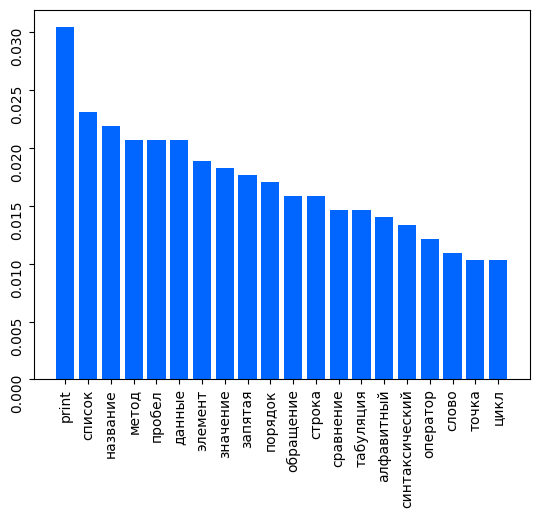

In [28]:
import matplotlib.pyplot as plt
plt.bar(list(a.keys())[:20], list(a.values())[:20], color='#0066FF')
plt.xticks(rotation=90)
plt.yticks(rotation=90)
plt.show()

#### 3. Статистика предложений

Описание: Средняя длина предложений, количество сложных предложений.
Применение: Помогает оценить читаемость и структуру текста.

In [29]:
avg_len_sent = 0
for comment in author_comment:
        doc = Doc(comment)
        doc.segment(segmenter)
        avg = 0
        for i in range(len(doc.sents)):
                avg += len(doc.sents[i].text.split(' '))
        avg_len_sent += avg / len(doc.sents)

avg_len_sent /= len(author_comment)
avg_len_sent

7.935683760683762

#### 4. Уникальные слова

Описание: Количество уникальных слов в тексте.
Применение: Позволяет оценить разнообразие словарного запаса.

In [30]:
a = []
for i in tokenized_texts:
        a.extend(i)
a = list(set(a))
len(a)

314

#### 7. Частота частей речи

Описание: Количество и процентное соотношение различных частей речи (существительные, глаголы, прилагательные и т.д.).
Применение: Помогает понять грамматическую структуру текста.

In [31]:
avg_part_of_speech_comment = []
for comment in author_comment:
        doc = Doc(comment)
        doc.segment(segmenter)
        doc.tag_morph(morph_tagger)
        for word in doc.tokens:
                avg_part_of_speech_comment.append(word.pos)
avg_part_of_speech_comment = Counter(avg_part_of_speech_comment)
avg_part_of_speech_comment

Counter({'NOUN': 2155,
         'PUNCT': 1550,
         'VERB': 897,
         'ADP': 671,
         'ADJ': 629,
         'ADV': 366,
         'X': 226,
         'DET': 221,
         'PRON': 218,
         'PART': 191,
         'CCONJ': 175,
         'SCONJ': 154,
         'AUX': 55,
         'NUM': 46,
         'PROPN': 38,
         'SYM': 8})

Существительное: 2155    
Знак препинания: 1550    
Глагол: 897    
Предлог: 671    
Прилагательное: 629    
Наречие: 366    
Неизвестный: 226    
Артикль: 221    
Местоимение: 218    
Частица: 191    
Сочинительный союз: 175    
Подчинительный союз: 154    
Вспомогательный глагол: 55   
Числительное: 46      
PСобственное имя: 38    
Символ: 8    

1. Длина текста    
Описание: Общее количество символов, слов и предложений.
Применение: Помогает оценить сложность текста и определить, подходит ли он для определенных алгоритмов.
avg_len_comment   -  143.41666666666666
avg_word_comment  -  19.471153846153847
avg_sent_comment  -  2.342948717948718


2. Частота слов    
Описание: Количество вхождений каждого слова в текст.    
Применение: Используется для анализа важности слов (например, TF-IDF) и выявления ключевых слов.


3. Статистика предложений. Описание: Средняя длина предложений, количество сложных предложений.
Применение: Помогает оценить читаемость и структуру текста.
Средняя длинна предложений - 7.935683760683762


4. Уникальные слова. Описание: Количество уникальных слов в тексте.
Применение: Позволяет оценить разнообразие словарного запаса.
Уникальных слов - 412


7. Частота частей речи. Описание: Количество и процентное соотношение различных частей речи (существительные, глаголы, прилагательные и т.д.).
Применение: Помогает понять грамматическую структуру текста.
Существительное: 2155
Знак препинания: 1550
Глагол: 897
Предлог: 671
Прилагательное: 629
Наречие: 366
Неизвестный: 226
Артикль: 221
Местоимение: 218
Частица: 191
Сочинительный союз: 175
Подчинительный союз: 154
Вспомогательный глагол: 55
Числительное: 46
PСобственное имя: 38
Символ: 8

#### графы

In [32]:
from graph_of_words import GraphOfWords

graph = GraphOfWords(window_size=2)
graph.build_graph(
    ' '.join(author_comment_lem),
    remove_stopwords=False,
    workers=4
)

graph.write_graph_edges('edges_list.txt')

In [33]:
with open('edges_list.txt', 'r') as file:
    content = file.read()
content.split('\n')

['некорректно использовать 2',
 'некорректно выполнять 2',
 'некорректно обрабатывать 2',
 'некорректно обращаться 2',
 'некорректно задать 2',
 'некорректно обновляете 2',
 'некорректно работать 2',
 'некорректно поставить 2',
 'некорректно проверять 2',
 'некорректно выводить 2',
 'некорректно реализовать 2',
 'некорректно обратабывать 2',
 'использовать метод 2',
 'использовать одинаковый 2',
 'использовать знак 2',
 'использовать переменный 2',
 'использовать быть 2',
 'использовать знако 2',
 'использовать неверный 2',
 'использовать некорректный 2',
 'использовать вы 2',
 'использовать также 2',
 'использовать print 2',
 'использовать двойной 2',
 'использовать скобка 2',
 'использовать функция 2',
 'использовать оператор 2',
 'метод добавление 2',
 'метод add 2',
 'метод append 2',
 'метод проверка 2',
 'метод upper 2',
 'метод list 2',
 'метод split 2',
 'метод для 2',
 'метод подсчет 2',
 'метод анализ 2',
 'метод который 2',
 'метод strip 2',
 'метод lower 2',
 'добавление эл

In [34]:
with open('edges_list.txt', 'r') as file:
    lines = file.readlines()
    lines = [line.strip()[:-2] for line in lines]
    lines_lists = [line.strip().split(' ') for line in lines]

print(lines)
print(lines_lists)

['некорректно использовать', 'некорректно выполнять', 'некорректно обрабатывать', 'некорректно обращаться', 'некорректно задать', 'некорректно обновляете', 'некорректно работать', 'некорректно поставить', 'некорректно проверять', 'некорректно выводить', 'некорректно реализовать', 'некорректно обратабывать', 'использовать метод', 'использовать одинаковый', 'использовать знак', 'использовать переменный', 'использовать быть', 'использовать знако', 'использовать неверный', 'использовать некорректный', 'использовать вы', 'использовать также', 'использовать print', 'использовать двойной', 'использовать скобка', 'использовать функция', 'использовать оператор', 'метод добавление', 'метод add', 'метод append', 'метод проверка', 'метод upper', 'метод list', 'метод split', 'метод для', 'метод подсчет', 'метод анализ', 'метод который', 'метод strip', 'метод lower', 'добавление элемент', 'добавление слово', 'добавление данные', 'элемент в', 'элемент словарь', 'элемент пара', 'элемент переменный', '

In [35]:
lines_lists = [line if line[0] not in list(author_comment_lem_counter.keys())[:25] + stop_wrods and line[1] not in list(author_comment_lem_counter.keys())[:25] + stop_wrods else 0 for line in lines_lists]
for i in range(len(lines_lists)):
        if lines_lists[i] == 0:
                lines[i] = 0

lines = [l for l in lines if l != 0]
lines_lists = [line for line in lines_lists if line != 0]

In [36]:
words = dict(Counter(' '.join([i for i in lines]).split(' ')))

In [109]:
import networkx as nx
import matplotlib.pyplot as plt

data = lines_lists
weights = words
attrs = {key:{"weight": val} for key,val in weights.items()}

G = nx.Graph()
G.add_edges_from(data)
nx.set_node_attributes(G, attrs)
node_size = [a["weight"]*600 for n,a in G.nodes(data=True)]

node_color = []
for n, a in G.nodes(data=True):
    weight = a["weight"] * 600
    if weight < 1000:
        node_color.append('#D0D1F1')
    elif weight < 2000:
        node_color.append('#9FA5E2')
    elif weight < 5000:
        node_color.append('#687BD3')  # средний вес
    elif weight < 7000:
        node_color.append('#0066FF')  # высокий вес
    else:
        node_color.append('#0054C3')  # очень высокий вес

fig, ax = plt.subplots(figsize=(200,200))
nx.draw(G, with_labels=True, node_size=node_size, node_color=node_color, font_color='Black', ax=ax)

plt.savefig('graph.png', dpi=100)

plt.show()